In [220]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from itertools import combinations 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import itertools

In [221]:
# get the train and test data from the input strings for the file locations
# ie train_data = "./data/Data1Train.csv"
def getData(train_data, test_data):
    """
    This function gets the test and train data from the input string in the form
    "./data/DataXTrain.csv"

    Args:
        train_data (string): A string for the training csv of the specified number
        test_data (string): A string for the test csv of the specified number

    Returns:
        X1_train (pandas df): A dataframe of the x and y values of the training csv
        Y1_train (pandas df): A dataframe of the class values of the training csv
        X1_test (pandas df): A dataframe of the x and y values of the test csv
        Y1_test (pandas df): A dataframe of the class values of the test csv
    """
    X1_df = pd.read_csv(train_data)
    X1T_df = pd.read_csv(test_data)

    X1_train = X1_df[['x', 'y']]
    Y1_train = X1_df[['Class']]
    X1_test = X1T_df[['x', 'y']]
    Y1_test = X1T_df[['Class']]

    return X1_train, Y1_train, X1_test, Y1_test

In [222]:
# create class Node that stores its children, model used, and is it a leaf
class Node:
    """
    A class for the Node object that will store the data for the tree

    Attributes:
        model: The best selected SVC for the training data
        isLeaf: Boolean value for if the node is a leaf or not
        Left: The Node to the left of self
        Right: The Node to the right of self
    """
    def __init__(self, model):
        # initializes default values for the Node object
        self.model = model
        self.isLeaf = True
        self.Left = None
        self.Right = None

    def setModel(self, model_in):
        # sets the Node model to the input model
        self.model = model_in

    def setRight(self, node_in):
        # sets the Right child of self with the input Node
        self.Right = node_in
        self.isLeaf = False

    def setLeft(self, node_in):
        # sets the Left child of self with the input Node
        self.Left = node_in
        self.isLeaf = False

    def is_leaf(self):
        # returns the isLeaf boolean attribute
        return self.isLeaf
    
    def get_model(self):
        # returns the Node's SVC model
        return self.model

    def print_tree(self):
        # testing only
        print(self.isLeaf)
        print(self.Right.isLeaf)
        print(self.Left.isLeaf)

In [223]:
def gini_index_one(X_train, Y_train, class_label_one, model):
    """
    This function calculates the Gini index for the case where there is one 
    class that is being separated from the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        class_label_one (int): The class that is being separated
        model (SVC): The model selected from training

    Returns:
        gini index value and direction to branch (below = left, above = right)
    """
    class_label_one = int(class_label_one)
    w = model.coef_[0]
    b = model.intercept_[0]
    merged = X_train.join(Y_train)
    filter_points = merged[merged['Class'] == class_label_one]
    # needs to be checked because vertical line has undefined slope
    if w[1] == 0:
        vertical_line = -b / w[0]
        left = 0
        right = 0
        # determine if the majority of the x values are left or right of vertical line
        for x in filter_points['x']:
            if x < vertical_line:
                left += 1
            else:
                right += 1
        # scoring for Gini index for fractions of data that are correct/incorrect
        left_correct = 0
        left_wrong= 0
        right_correct= 0
        right_wrong = 0
        if left > right:
            # label is correct if the x value is left of vertical line
            # the rest of the labels should be right of the line to be correct
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one:
                        left_correct += 1
                    else:
                        left_wrong += 1
                else:
                    if val == class_label_one:
                        right_wrong += 1
                    else:
                        right_correct += 1
            # calcluate the Gini values for the potential subtrees left and right
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            # calcualte the Gini index overall and return the direction to branch
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "below"
        else:
            # want the x values of the selected label to be right of the vertical line
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one:
                        left_wrong += 1
                    else:
                        left_correct += 1
                else:
                    if val == class_label_one:
                        right_correct += 1
                    else:
                        right_wrong += 1
            # calcluate the Gini values for the potential subtrees left and right            
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            # calcualte the Gini index overall and return the direction to branch
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "above"
    else: 
        # calculate the slope and intercept from the model for form y = mx+b
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        above = 0
        below = 0
        # determine if majority of points of class are above/below line
        for x,y in zip(filter_points['x'], filter_points['y']):
            if y < slope * x + intercept:
                below += 1
            else:
                above += 1
        above_correct = 0
        above_wrong = 0
        below_correct = 0
        below_wrong = 0
        if above >= below:
            # want the label points above line, others to be below
            print("Gini one using class " + str(class_label_one) + " is above")
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_correct += 1
                    else:
                        above_wrong += 1
                else:
                    if val == class_label_one:
                        below_wrong += 1
                    else:
                        below_correct += 1
            # calculate gini for points above/below line given by model
            above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
            below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
            # return the calculated Gini index from above/below and the direction to branch selected class
            return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "above"
        else:
            above_correct = 0
            above_wrong = 0
            below_correct = 0
            below_wrong = 0
            # want the current class to be below line, others to be above
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_wrong += 1
                    else:
                        above_correct += 1
                else:
                    if val == class_label_one:
                        print(type(val))
                        print(type(class_label_one))
                        below_correct += 1
                    else:
                        below_wrong += 1
                above_gini = 1
                if (above_correct+above_wrong) != 0:
                    above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
                below_gini = 1
                if (below_correct+below_wrong) != 0:
                    below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
                return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "below"

In [224]:
def gini_index_two(X_train, Y_train, class_label_one, class_label_two, model):
    """
    This function calculates the Gini index for the case where there is one 
    class that is being separated from the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        class_label_one (int): The class that is being separated
        model (SVC): The model selected from training

    Returns:
        gini index value and direction to branch (below = left, above = right)
    
    NOTE: See the inline comments for gini_index_one as they represent same functionality,
    just for the boundary of one class instead of two
    """
    class_label_one = int(class_label_one)
    class_label_two = int(class_label_two)
    selected = [class_label_one, class_label_two]
    w = model.coef_[0]
    b = model.intercept_[0]
    merged = X_train.join(Y_train)
    filter_points = merged[merged['Class'].isin(selected)]
    
    if w[1] == 0:
        vertical_line = -b / w[0]
        left = 0
        right = 0
        for x in filter_points['x']:
            if x < vertical_line:
                left += 1
            else:
                right += 1
        left_correct = 0
        left_wrong = 0
        right_correct = 0
        right_wrong = 0
        if left > right:
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one or val == class_label_two:
                        left_correct += 1
                    else:
                        left_wrong += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        right_wrong += 1
                    else:
                        right_correct += 1
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "below"
        else:
            for x, val in zip(merged['x'], merged['Class']):
                if x < vertical_line:
                    if val == class_label_one or val == class_label_two:
                        left_wrong += 1
                    else:
                        left_correct += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        right_correct += 1
                    else:
                        right_wrong += 1
            left_gini = 1 - (left_correct/(left_correct+left_wrong))**2 - (left_wrong/(left_correct+left_wrong))**2
            right_gini = 1 - (right_correct/(right_correct+right_wrong))**2 - (right_wrong/(right_correct+right_wrong))**2
            return (left_correct+left_wrong)/len(merged['x']) * left_gini + (right_correct+right_wrong)/len(merged['x']) * right_gini, "above"
    else:
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        above = 0
        below = 0
        for x,y in zip(filter_points['x'], filter_points['y']):
            if y < slope * x + intercept:
                below += 1
            else:
                above += 1
        above_correct = 0
        above_wrong = 0
        below_correct = 0
        below_wrong = 0
        if above >= below:
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one or val == class_label_two:
                        above_correct += 1
                    else:
                        above_wrong += 1
                else:
                    if val == class_label_one or val == class_label_two:
                        below_wrong += 1
                    else:
                        below_correct += 1
            above_gini = 1
            if (above_correct+above_wrong) != 0:
                above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
            below_gini = 1
            if (below_correct+below_wrong) != 0:
                below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
            return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "above"
        else:
            above_correct = 0
            above_wrong = 0
            below_correct = 0
            below_wrong = 0
            for x, y, val in zip(merged['x'], merged['y'], merged['Class']):
                if y >= slope * x + intercept:
                    if val == class_label_one:
                        above_wrong += 1
                    else:
                        above_correct += 1
                else:
                    if val == class_label_one:
                        below_correct += 1
                    else:
                        below_wrong += 1
                above_gini = 1
                if (above_correct+above_wrong) != 0:
                    above_gini = 1 - (above_correct/(above_correct+above_wrong))**2 - (above_wrong/(above_correct+above_wrong))**2
                below_gini = 1
                if (below_correct+below_wrong) != 0:
                    below_gini = 1 - (below_correct/(below_correct+below_wrong))**2 - (below_wrong/(below_correct+below_wrong))**2
                return (above_correct+above_wrong)/len(merged['x']) * above_gini + (below_correct+below_wrong)/len(merged['x']) * below_gini, "below"

In [225]:
# make a boundary for the class input. determine how many points are on correct side of boundary
# place this amount over total points and square value. 1 - left - right is gini index
# train model to separate class(es) from rest of data. run gini on it to see accuracy

def separate_one(X_train, Y_train, is_not_linear, class_label_one):
    """ 
    This function creates a SVC model to create a boundary between one class
    and the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        is_not_linear (boolean): determines which kernal of SVC to use
        class_label_one (int): The class selected to create boundary around

    Returns:
        model (SVC): The SVC model used to create the boundary
        acc (float): The Gini index
        direction (string): Which direction to branch the data
    """
    Y_bin = np.isin(Y_train, [class_label_one]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf', degree = 3)
    #print(Y_bin)
    model.fit(X_train, Y_bin)
    #print(model.coef_)
    acc, direction = gini_index_one(X_train, Y_train, class_label_one, model)
    print("Gini accuracy 1 " + str(acc) + " " + direction)
    return model, acc, direction

def separate_two(X_train, Y_train, is_not_linear, class_label_one, class_label_two):
    """ 
    This function creates a SVC model to create a boundary between two classes
    and the rest

    Args:
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
        is_not_linear (boolean): determines which kernal of SVC to use
        class_label_one (int): The first class selected to create boundary around
        class_label_two (int): The second class selected to create boundary around

    Returns:
        model (SVC): The SVC model used to create the boundary
        acc (float): The Gini index
        direction (string): Which direction to branch the data
    """
    Y_bin = np.isin(Y_train, [class_label_one, class_label_two]).astype(int)
    Y_bin = Y_bin.ravel()
    model = SVC(kernel='linear', degree=1)
    if is_not_linear:
        model = SVC(kernel='rbf', degree = 3)
    #print(Y_bin)
    model.fit(X_train, Y_bin)
    acc, direction = gini_index_two(X_train, Y_train, class_label_one, class_label_two, model)
    print("Gini accuracy 2 " + str(acc) + " " + direction)
    #print(model.coef_)
    return model, acc, direction

In [226]:
# build the tree
def build_tree(curr, classes, X_train, Y_train):
    """ 
    This function recursively builds the tree that contains the models as inner nodes and the
    classes as the leaves

    Args:
        curr (Node): The current Node for data to be placed in
        classes: The classes to be used for creating boundaries
        X_train (pandas df): The training data for x and y values
        Y_train (pandas df): The training data for the class values
    """
    # get all pairs of classes to create boundaries around
    class_pairs = list(itertools.combinations(classes, 2))
    best_model = None
    best_acc = 1.0
    best_direction = ""
    left_split = []
    right_split = []

    # iterate over a single class first and create a boundary to separate it 
    # from the rest of the classes
    for val in classes:
        curr_model, curr_acc, curr_direction = separate_one(X_train, Y_train, False, val)
        # if the current model has a lower or equal Gini index than the best,
        # set the best values to the current ones
        if curr_acc <= best_acc:
            best_model = curr_model
            best_acc = curr_acc
            best_direction = curr_direction
            # sort the classes and determine how to branch them for the subtree
            if best_direction == "below":
                left_split = np.array([val])
                right_split = classes[classes != val]
            else:
                right_split = np.array([val])
                left_split = classes[classes != val]
    # executes when there are 3 or more classes in the data set to create boundaries for          
    if len(class_pairs) > 2:
        for class_label_one, class_label_two in class_pairs:
            curr_model, curr_acc, curr_direction = separate_two(X_train, Y_train, False, class_label_one, class_label_two)
            if curr_acc <= best_acc:
                best_model = curr_model
                best_acc = curr_acc
                best_direction = curr_direction
                val_arr = [class_label_one, class_label_two]
                if best_direction == "below":
                    left_split = np.array(val_arr)
                    right_split = classes[~np.isin(classes, val_arr)]
                else:
                    right_split = np.array(val_arr)
                    left_split = classes[~np.isin(classes, val_arr)]
    # case when we are down to 0 or 1 values to be split for both sides of tree
    if len(left_split) < 2 and len(right_split) < 2:
        curr.setModel(best_model)
        if len(left_split) > 0:
            curr.setLeft(Node(left_split[0]))
        else:
            # since we have a binary tree, one leaf is ignored when one value was remaining
            curr.setLeft(Node("ignore"))
        if len(right_split) > 0:
            curr.setRight(Node(right_split[0]))
        else:
            curr.setRight("ignore")
        return
    # case when the left side of the tree is down to 0 or 1 values to be split
    elif len(left_split) < 2:
        curr.setModel(best_model)
        if len(left_split) > 0:
            curr.setLeft(Node(left_split[0]))
        else:
            curr.setLeft(Node("ignore"))
        # we still need to build out right subtree since more than two nodes remain
        # to be separated with boundaries
        merged = X_train.join(Y_train)
        filter_right = merged[merged['Class'].isin(right_split)]
        X_train_right = filter_right[['x', 'y']]
        Y_train_right = filter_right[['Class']]
        curr.setRight(Node(None))
        build_tree(curr.Right, right_split, X_train_right, Y_train_right)
    # case when right side of tree is down to 0 or 1 values to be split
    elif len(right_split) < 2:
        curr.setModel(best_model)
        if len(right_split) > 0:
            curr.setRight(Node(right_split[0]))
        else:
            curr.setRight("ignore")
        merged = X_train.join(Y_train)
        filter_left = merged[merged['Class'].isin(left_split)]
        X_train_left = filter_left[['x', 'y']]
        Y_train_left = filter_left[['Class']]
        curr.setLeft(Node(None))
        build_tree(curr.Left, left_split, X_train_left, Y_train_left)
    else:
        # filter all of the data, divide it into left and right subtrees, and
        # recursively build on those two subtrees
        merged = X_train.join(Y_train)
        filter_left = merged[merged['Class'].isin(left_split)]
        filter_right = merged[merged['Class'].isin(right_split)]
        X_train_left = filter_left[['x', 'y']]
        Y_train_left = filter_left[['Class']]
        X_train_right = filter_right[['x', 'y']]
        Y_train_right = filter_right[['Class']]
        curr.setModel(best_model)
        curr.setLeft(Node(None))
        curr.setRight(Node(None))
        build_tree(curr.Left, left_split, X_train_left, Y_train_left)
        build_tree(curr.Right, right_split, X_train_right, Y_train_right)

In [227]:
# run for data 1
X_train, Y_train, X_test, Y_test = getData('./data/Data1Train.csv', './data/Data1Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
#class_pairs = [(1, 2), (1, 3), (2, 3)]
classes = Y_train['Class'].unique()
print(type(classes))
root_one = Node(None)
curr = root_one

build_tree(curr, classes, X_train, Y_train)
root_one.print_tree()

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini one using class 1 is above
Gini accuracy 1 0.0 above
Gini one using class 2 is above
Gini accuracy 1 0.0 above
Gini accuracy 1 0.0 below
Gini accuracy 2 0.0 below
Gini accuracy 2 0.0 above
Gini accuracy 2 0.0 below
Gini accuracy 2 0.0 above
Gini accuracy 2 0.0 below
Gini accuracy 2 0.27776958978138055 above
Gini one using class 1 is above
Gini accuracy 1 0.0 above
Gini accuracy 1 0.0 below
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini one using class 2 is above
Gini accuracy 1 0.0 above
False
False
False


In [228]:
# plot utility functions

def get_models(curr, model_arr):
    if curr.is_leaf():
        return model_arr
    model_arr.append(curr.get_model())
    model_arr = get_models(curr.Left, model_arr)
    model_arr = get_models(curr.Right, model_arr)

def classify_point(curr, x_in, y_in):
    while not curr.is_leaf():
        w = curr.model.coef_[0]
        b = curr.model.intercept_[0]
        if w[1] == 0:
            vertical_line = -b / w[0]
            if x_in < vertical_line:
                curr = curr.Left
            else:
                curr = curr.Right
        else:
            slope = -w[0] / w[1]
            intercept = -b / w[1]
            if y_in < slope * x_in + intercept:
                curr = curr.Left
            else:
                curr = curr.Right
    return curr.model
        

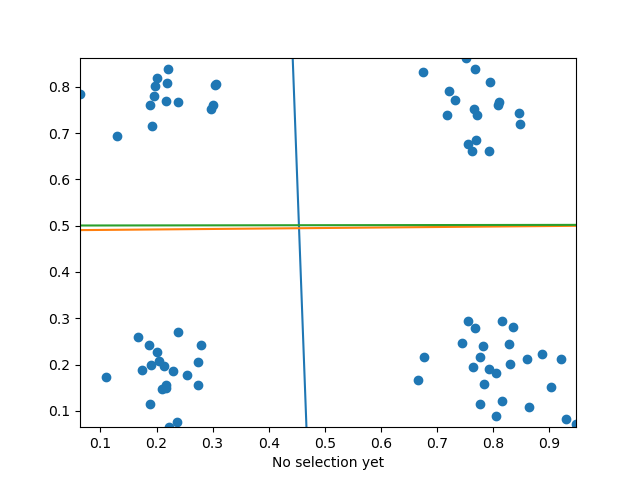

In [229]:
# interactive plot for data 1
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()


root_model = root_one.model
left_model = root_one.Left.model
right_model = root_one.Right.model

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')
model_list = [root_model, left_model, right_model]
for model in model_list:
    minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
    maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
    plt.plot([minX0D,maxX0D],[minX1,maxX1])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        classified = classify_point(root_one, event.xdata, event.ydata)
        tx = tx + ' Class ' + str(classified) + ' is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')

        for model in model_list:
            minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
            maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
            plt.plot([minX0D,maxX0D],[minX1,maxX1])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [230]:
# run for data 2
X_train, Y_train, X_test, Y_test = getData('./data/Data2Train.csv', './data/Data2Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
#class_pairs = [(1, 2), (1, 3), (2, 3)]
classes = Y_train['Class'].unique()
print(type(classes))
root_two = Node(None)
curr = root_two

build_tree(curr, classes, X_train, Y_train)
root_two.print_tree()

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini accuracy 1 0.0 below
Gini one using class 2 is above
Gini accuracy 1 0.0 above
Gini one using class 1 is above
Gini accuracy 1 0.0 above
Gini accuracy 2 0.0 below
Gini accuracy 2 0.3191366574330563 above
Gini accuracy 2 0.0 above
Gini accuracy 2 0.0 below
Gini accuracy 2 0.0 below
Gini accuracy 2 0.0 above
Gini one using class 3 is above
Gini accuracy 1 0.0 above
Gini accuracy 1 0.0 below
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini one using class 1 is above
Gini accuracy 1 0.0 above
False
False
False


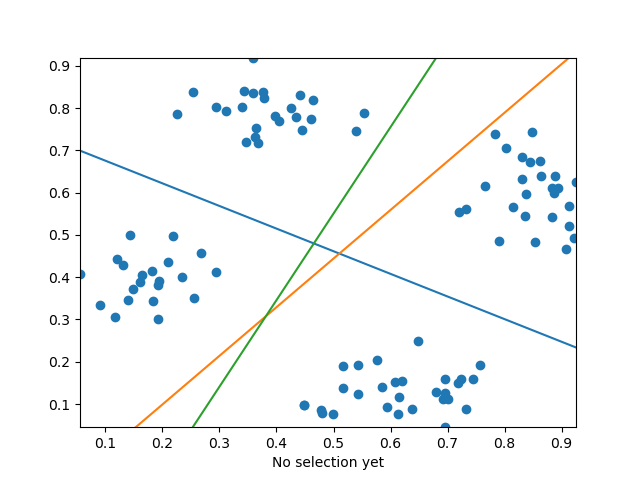

In [231]:
# interactive plot for data 2
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()


root_model = root_two.model
left_model = root_two.Left.model
right_model = root_two.Right.model

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')

model_list = [root_model, left_model, right_model]
for model in model_list:
    minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
    maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
    plt.plot([minX0D,maxX0D],[minX1,maxX1])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        classified = classify_point(root_two, event.xdata, event.ydata)
        tx = tx + ' Class ' + str(classified) + ' is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')

        for model in model_list:
            minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
            maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
            plt.plot([minX0D,maxX0D],[minX1,maxX1])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [232]:
# run for data 3
X_train, Y_train, X_test, Y_test = getData('./data/Data3Train.csv', './data/Data3Test.csv')
class_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
#class_pairs = [(1, 2), (1, 3), (2, 3)]
classes = Y_train['Class'].unique()
print(type(classes))
root_three = Node(None)
curr = root_three

build_tree(curr, classes, X_train, Y_train)
root_three.print_tree()

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini one using class 2 is above
Gini accuracy 1 0.2261012311901504 above
Gini one using class 3 is above
Gini accuracy 1 0.2232492001421969 above
Gini accuracy 2 0.0 below
Gini accuracy 2 0.0 below
Gini accuracy 2 0.2038833307941022 above
<class 'int'>
<class 'int'>
Gini accuracy 1 0.0 below
Gini one using class 3 is above
Gini accuracy 1 0.05749198717948722 above
False
True
False


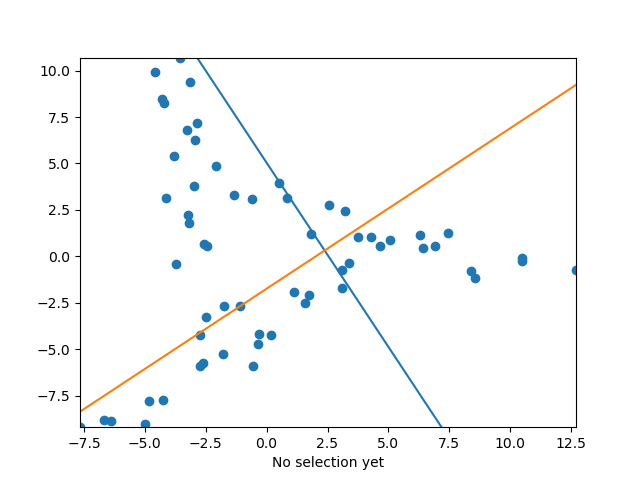

In [233]:
# interactive plot for data 2
%matplotlib widget
minX0D = X_test['x'].min()
maxX0D = X_test['x'].max()
minX1D = X_test['y'].min()
maxX1D = X_test['y'].max()


root_model = root_three.model
left_model = root_three.Left.model

fig, ax = plt.subplots()

plt.scatter(X_test['x'], X_test['y'], marker='o')

model_list = [root_model, left_model]
for model in model_list:
    minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
    maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
    plt.plot([minX0D,maxX0D],[minX1,maxX1])
ax.set_xlim([minX0D, maxX0D])
ax.set_ylim([minX1D, maxX1D])

text=plt.xlabel("No selection yet")

def onclick(event):
    if event.inaxes is not None:
        tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
        classified = classify_point(root_three, event.xdata, event.ydata)
        tx = tx + ' Class ' + str(classified) + ' is selected'

        plt.cla()
        plt.scatter(X_test['x'], X_test['y'], marker='o')

        for model in model_list:
            minX1 = (-model.intercept_-model.coef_[0,0]*minX0D)/model.coef_[0,1]
            maxX1 = (-model.intercept_-model.coef_[0,0]*maxX0D)/model.coef_[0,1]
            plt.plot([minX0D,maxX0D],[minX1,maxX1])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])
        ax.scatter([event.xdata],[event.ydata],c='r')
            
        text.set_text(tx)
        fig.canvas.draw()
    else:
        print('Clicked outside of an axis.')

cid = fig.canvas.mpl_connect('button_press_event', onclick)